In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime as dt
import sklearn
import pandas_datareader as web
import pypfopt
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import pandas_ta
import warnings

warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
#not survivorship bias free...

end_date = '2024-04-18'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [3]:
df = yf.download(
    tickers = symbols_list,
    start = start_date,
    end = end_date
)

[*********************100%%**********************]  503 of 503 completed


In [4]:
df = df.stack()

In [5]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-20 A        38.961636   41.520000   41.680000   41.299999   41.419998   
           AAL      39.537514   41.259998   41.709999   41.110001   41.360001   
           AAPL     24.483658   26.782499   27.022499   26.514999   26.660000   
           ABBV     42.861233   60.480000   61.110001   59.959999   60.169998   
           ABT      37.950703   43.970001   44.580002   43.509998   44.480000   
...                       ...         ...         ...         ...         ...   
2024-04-17 XYL     126.220001  126.220001  128.490005  124.660004  128.490005   
           YUM     137.830002  137.830002  138.880005  137.360001  138.559998   
           ZBH     121.300003  121.300003  122.870003  120.040001  122.870003   
           ZBRA    276.140015  276.140015  284.489990  275.750000  283.519989   
           ZTS     151.508011  151.940002  153.179993  151.240005  153.009995   

Price                   volume  
date       ticker               
2016-04-20 A         1243900.0  
           AAL       5018200.0  
           AAPL    122444000.0  
           ABBV      4443600.0  
           ABT       8693500.0  
...                        ...  
2024-04-17 XYL       1441300.0  
           YUM       1516600.0  
           ZBH       1521600.0  
           ZBRA       175600.0  
           ZTS       3270500.0  

[991990 rows x 6 columns]

CALCULATE FEATURES + INDICATORS FOR EACH STOCK

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

Garman-Klass Volatility = 0.5(ln(high/low))^2 - (2ln(2)-1)(ln(adj_close/open))^2
- used in FX --> it is the intraday volatility

In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open'])))**2

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
#ticker level --> level=0 is date

def safe_bbands(series, id, length=20):
    # Using logarithm of prices to compute Bollinger Bands
    log_prices = np.log1p(series)
    bbands = pandas_ta.bbands(close=log_prices, length=length)
    
    if bbands is not None:
        return bbands[id]  # Adjust the column name based on your pandas_ta configuration
    else:
        # Return NaN for groups with insufficient data
        return pd.Series([np.nan] * len(series), index=series.index)

# Apply the function to each group
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: safe_bbands(x, id='BBL_20_2.0'))
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: safe_bbands(x, id='BBM_20_2.0'))
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: safe_bbands(x, id='BBU_20_2.0'))

def compute_atr(stock_data):
    # Ensure there is enough data
    if len(stock_data) < 14:
        return pd.Series(np.nan, index=stock_data.index)

    # Calculate ATR
    atr = pandas_ta.atr(
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14
    )
    
    # Check if ATR calculation was successful
    if atr is None:
        return pd.Series(np.nan, index=stock_data.index)
    
    # Standardize the ATR values
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys = False).apply(compute_atr)


def compute_macd(close):
  
    macd = pandas_ta.macd(close=close, fast=12, slow=26, signal=9)
    if macd is None:
        return pd.Series([np.nan] * len(close), index=close.index)
    else:
        macd = macd.iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False).apply(lambda x: compute_macd(x['close']))

In [7]:
#just so we don't have to redo

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [8]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-20 A        38.961636   41.520000   41.680000   41.299999   41.419998   
           AAL      39.537514   41.259998   41.709999   41.110001   41.360001   
           AAPL     24.483658   26.782499   27.022499   26.514999   26.660000   
           ABBV     42.861233   60.480000   61.110001   59.959999   60.169998   
           ABT      37.950703   43.970001   44.580002   43.509998   44.480000   
...                       ...         ...         ...         ...         ...   
2024-04-17 XYL     126.220001  126.220001  128.490005  124.660004  128.490005   
           YUM     137.830002  137.830002  138.880005  137.360001  138.559998   
           ZBH     121.300003  121.300003  122.870003  120.040001  122.870003   
           ZBRA    276.140015  276.140015  284.489990  275.750000  283.519989   
           ZTS     151.508011  151.940002  153.179993  151.240005  153.009995   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-04-20 A         1243900.0         -0.001404        NaN       NaN   
           AAL       5018200.0         -0.000680        NaN       NaN   
           AAPL    122444000.0         -0.002622        NaN       NaN   
           ABBV      4443600.0         -0.044267        NaN       NaN   
           ABT       8693500.0         -0.009440        NaN       NaN   
...                        ...               ...        ...       ...   
2024-04-17 XYL       1441300.0          0.000335  49.809525  4.849245   
           YUM       1516600.0          0.000050  53.491621  4.906562   
           ZBH       1521600.0          0.000208  40.080743  4.810873   
           ZBRA       175600.0          0.000218  44.801746  5.633697   
           ZTS       3270500.0          0.000044  29.696030  5.017917   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-04-20 A            NaN       NaN       NaN       NaN      48.464379  
           AAL          NaN       NaN       NaN       NaN     198.407151  
           AAPL         NaN       NaN       NaN       NaN    2997.877000  
           ABBV         NaN       NaN       NaN       NaN     190.458174  
           ABT          NaN       NaN       NaN       NaN     329.924434  
...                     ...       ...       ...       ...            ...  
2024-04-17 XYL     4.862350  4.875454  0.324379  0.033237     181.920888  
           YUM     4.929752  4.952942  0.215284  0.025102     209.032981  
           ZBH     4.854244  4.897615 -0.330081 -0.381769     184.570085  
           ZBRA    5.684206  5.734715  0.141865 -0.046420      48.490187  
           ZTS     5.099046  5.180175  1.177157 -3.080020     495.506950  

[991990 rows x 14 columns]

In [44]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

x = df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')
y = df.unstack()[last_cols].resample('M').last().stack('ticker')

data = pd.concat([x, y], axis=1).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-05-31 A          104.556234   43.062359         -0.001415  76.993507   
           AAL        304.649000   30.666256         -0.000261  28.660937   
           AAPL      3737.581339   22.961119         -0.002413  53.806722   
           ABBV       427.814813   44.597504         -0.044787  59.311839   
           ABT        396.860955   34.204830         -0.007440  46.526362   
...                          ...         ...               ...        ...   
2024-04-30 XYL        127.028105  126.220001          0.000335  49.809525   
           YUM        265.232359  137.830002          0.000050  53.491621   
           ZBH        140.554063  121.300003          0.000208  40.080743   
           ZBRA        87.835509  276.140015          0.000218  44.801746   
           ZTS        630.710660  151.508011          0.000044  29.696030   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-05-31 A       3.652142  3.731073  3.810004 -1.321694  0.630101  
           AAL     3.423399  3.470762  3.518124 -0.089961 -1.661864  
           AAPL    3.067554  3.128054  3.188554 -1.159597 -0.211216  
           ABBV    3.758098  3.800015  3.841933 -1.103651 -0.245310  
           ABT     3.494111  3.524376  3.554641 -1.225342 -0.835492  
...                     ...       ...       ...       ...       ...  
2024-04-30 XYL     4.849245  4.862350  4.875454  0.324379  0.033237  
           YUM     4.906562  4.929752  4.952942  0.215284  0.025102  
           ZBH     4.810873  4.854244  4.897615 -0.330081 -0.381769  
           ZBRA    5.633697  5.684206  5.734715  0.141865 -0.046420  
           ZTS     5.017917  5.099046  5.180175  1.177157 -3.080020  

[47324 rows x 9 columns]

In [45]:
#calculate 5 year rolling avg dollar volume for each stock
#get this to filter out top 150 most liquid stocks for each month

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# CALCULATING MONTHLY RETURNS FOR DIFFERENT TIME HORIZONS

In [46]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m'] = (
            df['adj close'].pct_change(lag).pipe(
                lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff))
            ).add(1).pow(1/lag).sub(1)
        )
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [47]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-04-30 AAL      41.922890         -0.000233  34.064594  3.733074   
           AAPL     39.177341          0.000096  44.093158  3.663645   
           ABBV     73.473633         -0.034027  47.693798  4.220003   
           ABT      52.480820         -0.006101  45.310109  3.969568   
           ACN     138.647690         -0.003740  47.986167  4.904240   
...                       ...               ...        ...       ...   
2024-04-30 VRTX    393.100006          0.000110  36.505989  5.969546   
           VZ       39.779999          0.000085  47.081768  3.689398   
           WFC      57.180000          0.000136  57.488314  4.047643   
           WMT      59.650002          0.000076  52.198621  4.094296   
           XOM     118.629997          0.000178  64.310630  4.727352   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-04-30 AAL     3.847312  3.961549  2.131129 -2.546087  -0.173787   
           AAPL    3.720439  3.777232 -0.830704 -0.521221  -0.015020   
           ABBV    4.270969  4.321936  0.969432 -1.089789   0.030640   
           ABT     3.991923  4.014279 -0.575634 -0.464623  -0.025203   
           ACN     4.936702  4.969163 -0.531550 -0.368329  -0.006292   
...                     ...       ...       ...       ...        ...   
2024-04-30 VRTX    6.012310  6.055075  0.696453 -1.796646  -0.059592   
           VZ      3.728511  3.767623 -0.666048 -0.193231  -0.036602   
           WFC     4.063390  4.079138  0.089612  0.327981  -0.013458   
           WMT     4.113545  4.132794  0.301262 -0.073059  -0.008642   
           XOM     4.778532  4.829713  0.378517  1.885171   0.020561   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-04-30 AAL     -0.110429  -0.074851  -0.013677  -0.017083    0.001295  
           AAPL    -0.036776  -0.002988  -0.002490   0.013081    0.013071  
           ABBV    -0.082295  -0.045625   0.014256   0.039338    0.035160  
           ABT     -0.016043  -0.020529   0.013257   0.020388    0.025886  
           ACN     -0.026676  -0.017233   0.011571   0.020044    0.020096  
...                      ...        ...        ...        ...         ...  
2024-04-30 VRTX    -0.033405  -0.031994   0.013780   0.012237    0.011986  
           VZ       0.005037  -0.015394   0.026528   0.023444    0.008017  
           WFC      0.014200   0.046930   0.065198   0.026769    0.033469  
           WMT      0.010550   0.028069   0.016459   0.013813    0.015491  
           XOM      0.065363   0.052105   0.022302   0.014263    0.003139  

[10502 rows x 14 columns]

## downwload fama-french factors and calculate rollingg factor betas

In [48]:
#use to find risk-return nature

factor_data = web.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

#data_simple = data['return_1m'].reset_index(level='ticker', drop=True)

factor_data = factor_data.join(data['return_1m']).sort_index()


factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173787
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025203
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006292
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.029166
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.055018
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.115593
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.064024
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.026081

[10216 rows x 6 columns]

In [49]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [50]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173787
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025203
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006292
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.029166
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.055018
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.115593
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.064024
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.026081

[10180 rows x 6 columns]

## calculate rolling factor betas

In [51]:
betas = (factor_data.groupby(level=1, group_keys=False).apply(
    lambda x: RollingOLS(endog=x['return_1m'], 
                         exog=sm.add_constant(x.drop('return_1m', axis=1)), 
                         window=min(24, x.shape[0]),
                         min_nobs=len(x.columns)+1)
    .fit(params_only=True).params.drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-04-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-02-29 VRTX    0.326829  0.592502 -0.880360  0.213540  1.148968
           VZ      0.465110 -1.123146  0.785972  0.143685 -0.493699
           WFC     1.130585  0.277845  1.569919 -0.359531 -1.258984
           WMT     0.551394  0.245392 -0.959622  0.587579  0.954838
           XOM     0.812998 -0.009066  0.464574  0.827790  0.579605

[10180 rows x 5 columns]

In [52]:
data = (data.join(betas.groupby('ticker').shift()))

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(
      lambda x: x.fillna(x.mean()))


In [53]:
data = data.drop('adj close', axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10333 entries, (Timestamp('2018-04-30 00:00:00'), 'AAL') to (Timestamp('2024-04-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10333 non-null  float64
 1   rsi               10333 non-null  float64
 2   bb_low            10333 non-null  float64
 3   bb_mid            10333 non-null  float64
 4   bb_high           10333 non-null  float64
 5   atr               10333 non-null  float64
 6   macd              10333 non-null  float64
 7   return_1m         10333 non-null  float64
 8   return_2m         10333 non-null  float64
 9   return_3m         10333 non-null  float64
 10  return_6m         10333 non-null  float64
 11  return_9m         10333 non-null  float64
 12  return_12m        10333 non-null  float64
 13  Mkt-RF            10333 non-null  float64
 14  SMB               10333 non-null  float64
 15  HML        

# K-means clustering ML algorithm

In [54]:
#each stock is assigned a cluster

from sklearn.cluster import KMeans

# most of the strategy is focused around momentum or RSI (relative strength index)
# so we wish to get stocks clustered around largest RSIs
# so can't generate randomized centroids 

target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 1] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(
        n_clusters=4,
        random_state=0,
        init=initial_centroids
    ).fit(df).labels_

    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-04-30 AAL            -0.000233  34.064594  3.733074  3.847312  3.961549   
           AAPL            0.000096  44.093158  3.663645  3.720439  3.777232   
           ABBV           -0.034027  47.693798  4.220003  4.270969  4.321936   
           ABT            -0.006101  45.310109  3.969568  3.991923  4.014279   
           ACN            -0.003740  47.986167  4.904240  4.936702  4.969163   
...                             ...        ...       ...       ...       ...   
2024-04-30 VRTX            0.000110  36.505989  5.969546  6.012310  6.055075   
           VZ              0.000085  47.081768  3.689398  3.728511  3.767623   
           WFC             0.000136  57.488314  4.047643  4.063390  4.079138   
           WMT             0.000076  52.198621  4.094296  4.113545  4.132794   
           XOM             0.000178  64.310630  4.727352  4.778532  4.829713   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-04-30 AAL     2.131129 -2.546087  -0.173787  -0.110429  -0.074851   
           AAPL   -0.830704 -0.521221  -0.015020  -0.036776  -0.002988   
           ABBV    0.969432 -1.089789   0.030640  -0.082295  -0.045625   
           ABT    -0.575634 -0.464623  -0.025203  -0.016043  -0.020529   
           ACN    -0.531550 -0.368329  -0.006292  -0.026676  -0.017233   
...                     ...       ...        ...        ...        ...   
2024-04-30 VRTX    0.696453 -1.796646  -0.059592  -0.033405  -0.031994   
           VZ     -0.666048 -0.193231  -0.036602   0.005037  -0.015394   
           WFC     0.089612  0.327981  -0.013458   0.014200   0.046930   
           WMT     0.301262 -0.073059  -0.008642   0.010550   0.028069   
           XOM     0.378517  1.885171   0.020561   0.065363   0.052105   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-04-30 AAL     -0.013677  -0.017083    0.001295  1.235768  1.410400   
           AAPL    -0.002490   0.013081    0.013071  1.323504 -0.361609   
           ABBV     0.014256   0.039338    0.035160  0.456358  0.554741   
           ABT      0.013257   0.020388    0.025886  0.807180 -0.145281   
           ACN      0.011571   0.020044    0.020096  1.221935 -0.177725   
...                      ...        ...         ...       ...       ...   
2024-04-30 VRTX     0.013780   0.012237    0.011986  0.512960  0.005872   
           VZ       0.026528   0.023444    0.008017  0.474464 -0.398787   
           WFC      0.065198   0.026769    0.033469  1.066169 -0.078863   
           WMT      0.016459   0.013813    0.015491  0.602103 -0.413936   
           XOM      0.022302   0.014263    0.003139  1.099171  0.211199   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-04-30 AAL     0.484432  0.136416  0.796569        0  
           AAPL   -0.620725  0.463088  0.619576        1  
           ABBV   -0.170314  0.517058  0.383724        1  
           ABT    -0.479252  0.278063  0.966560        1  
           ACN    -0.279863  0.316912  0.140890        1  
...                     ...       ...       ...      ...  
2024-04-30 VRTX   -0.877562  0.134695  0.857166        0  
           VZ      0.162792  0.254400  0.329782        2  
           WFC     1.535922 -0.742869 -0.771127        3  
           WMT    -0.351968  0.274734  0.690450        2  
           XOM     0.776841 -0.472599  0.525221        3  

[10333 rows x 19 columns]

In [55]:
# visualize clusters

def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return



In [56]:
plt.style.use('ggplot')

# for i in data.index.get_level_values('date').unique().tolist():
#     g = data.xs(i, level=0)
#     plt.title(f'Date {i}')
#     plot_clusters(g)

#CLUSTER 3 is are the stocks with largest RSI

## For each month select assets with largest RSI and make porftolio
### it will be based on Efficient Frontier max sharpe ratio optimization

In [57]:
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

## define portfolio optimization function

In [58]:
import sys
!{sys.executable} -m pip install PyPortfolioOpt

In [59]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# find weights for every month

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(
        expected_returns=returns,
        cov_matrix=cov,
        weight_bounds=(lower_bound,0.2),
        solver='SCS')

    weights = ef.max_sharpe()
    return ef.clean_weights()

In [60]:
# need 1 year prior to get data

stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks, 
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-01  40.753742   34.207825   48.931122   38.478344  109.154366   
2017-05-02  42.487328   34.424862   49.041512   38.584534  108.641205   
2017-05-03  42.535748   34.319836   49.122471   38.690746  108.299110   
2017-05-04  42.526066   34.196152   49.483147   39.460648  108.767235   
2017-05-05  43.107155   34.763252   49.306484   39.504902  109.397408   
...               ...         ...         ...         ...         ...   
2024-04-15  12.940000  172.690002  161.669998  108.889999  313.269989   
2024-04-16  13.030000  169.380005  162.539993  109.209999  313.940002   
2024-04-17  13.890000  168.000000  164.250000  105.900002  314.540009   
2024-04-18  14.020000  167.039993  164.660004  105.269997  316.000000   
2024-04-19  14.110000  165.000000  166.410004  107.279999  316.880005   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-05-01  135.110001   89.700394   91.980003  51.175190   38.453987  ...   
2017-05-02  135.000000   89.734940   93.449997  51.108742   38.463207  ...   
2017-05-03  134.850006   84.127022   93.349998  51.117054   38.315666  ...   
2017-05-04  134.610001   85.498810   93.250000  52.055660   38.380219  ...   
2017-05-05  134.839996   85.662727   93.239998  52.088886   38.573872  ...   
...                ...         ...         ...        ...         ...  ...   
2024-04-15  470.100006  244.080002  229.619995  73.050003  205.679993  ...   
2024-04-16  476.220001  244.210007  228.240005  73.809998  209.479996  ...   
2024-04-17  474.450012  242.899994  214.919998  72.580002  199.889999  ...   
2024-04-18  473.179993  241.990005  210.630005  72.989998  194.320007  ...   
2024-04-19  465.019989  243.309998  216.500000  74.230003  189.770004  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-05-01   9042100  5432900  2108800  14455200   3380000  8368400  13915800   
2017-05-02  11627700  4476300  2465400  13397800   4013900  4849300  15634900   
2017-05-03   4909000  2993300  1333300  19568100   3288400  4382100  15737100   
2017-05-04   5257000  3068300  1672700  20767700   3561500  3337800  17054100   
2017-05-05   8844500  4668900  2545100  17133000   4187100  3057000  13078800   
...              ...      ...      ...       ...       ...      ...       ...   
2024-04-15  10267500  2413500  1373700  16442800  10502000  5627400  19407500   
2024-04-16   8237100  2126300   695400  14016800   8548400  4467700  25620000   
2024-04-17   5940900  2469700   881000  21009200   7699300  6524400  18867700   
2024-04-18   8231800  3115000   949100  20173700   6754800  4347200  24468500   
2024-04-19   7826200  2437500  1342000  24693500  10863100  7029800  34330900   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-05-01  18497700  2138700   8664100  
2017-05-02  21955200  1497500   9102900  
2017-05-03  16570800  1322800  10289000  
2017-05-04  16502400  1423300  16164500  
2017-05-05  16793400  3086100  10213000  
...              ...      ...       ...  
2024-04-15  10557200  1772200  15029500  
2024-04-16  14726300  1341300  18082200  
2024-04-17  15329700  1904000  14538600  
2024-04-18  12061500  1786200  13821400  
2024-04-19  14160200  1165300  21566500  

[1755 rows x 942 columns]

## calculate daily returns for each stock which could land in our portfolio
## loop over each month start, select the stocks for the month and calculate their weights for next month
## if max sharpe ratio optimizatoins fails for a given month, apply equally-weighted weights (portfolio diversification)
## calculate each day portfolio return

In [61]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
        cols = fixed_dates[start_date]
    
        #calculate weights
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:    
            equally_weighted_lb = round(1/(len(optimization_df.columns)*2),3)
            
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=equally_weighted_lb
            )
            success = True
        except:
            print(f'Max Sharpe Ratio Optimization failed for {start_date}. Continuing with equal weights')

        if success == False:
            weights = pd.DataFrame([1/(len(optimization_df.columns)) for i in range(len(optimization_df.columns))],
                                  index = optimization_df.columns.tolist(),
                                  columns = pd.Series(0)).T
    
        weights = pd.DataFrame(weights, index=pd.Series(0))
    
        temp_df = returns_dataframe[start_date:end_date]
    
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True)\
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)
        
    

Max Sharpe Ratio Optimization failed for 2020-03-01. Continuing with equal weights
Max Sharpe Ratio Optimization failed for 2020-04-01. Continuing with equal weights
Max Sharpe Ratio Optimization failed for 2021-02-01. Continuing with equal weights
Max Sharpe Ratio Optimization failed for 2022-10-01. Continuing with equal weights
'return'


In [62]:
portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

,Strategy Return
date,
2018-05-01,-0.003454
2018-05-02,-0.000383
2018-05-03,0.001606
2018-05-04,0.004324
2018-05-07,-0.001869
...,...
2024-04-15,-0.004897
2024-04-16,-0.000609
2024-04-17,-0.003551


# Visualize portoflio and compare with SPX

In [63]:
spy = yf.download(tickers='SPY',
                  start='2016-01-01',
                  end=dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [64]:
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'Spy Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(
    spy_ret, left_index=True, right_index=True)

portfolio_df

,Strategy Return,Spy Buy&Hold
2018-05-01,-0.003454,0.001775
2018-05-02,-0.000383,-0.006740
2018-05-03,0.001606,-0.002206
2018-05-04,0.004324,0.012863
2018-05-07,-0.001869,0.003378
...,...,...
2024-04-12,-0.021303,-0.013899
2024-04-15,-0.004897,-0.012607
2024-04-16,-0.000609,-0.001825
2024-04-17,-0.003551,-0.005936


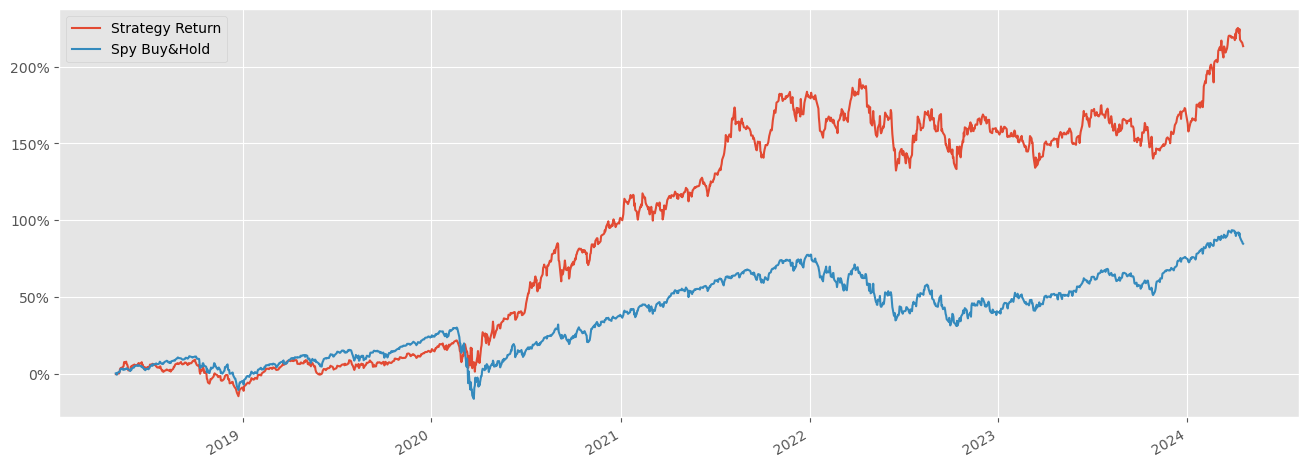

In [66]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulatitve_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulatitve_return

portfolio_cumulatitve_return.plot(figsize=(16,6))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()